## Acrobot

The [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/) is a classic problem in control theory. The environment consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

- The action space is discrete, deterministic, and represents the torque applied on the actuated joint between the two links: (0) apply -1 torque, (1) apply 0 torque to the actuated joint, (2) apply 1 torque to the actuated joint
- The observation space is a 6-dimensional space with the sine and cosine of the two joint angles and their angular velocities.

The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

1 - import the environment from Gymnasium and show it with a random policy

In [1]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'Acrobot-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium

env_name = 'Acrobot-v1' 
env = gymnasium.make(env_name, render_mode="rgb_array")

2 - Show the policy in action by rendering the environment several times after different decisions from a random policy:

In [2]:
# YOUR CODE HERE

# You can use the same function already used for the cartpole environment

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from itertools import count

def show_policy(env, agent, n_episodes=1, max_steps=500):
    for episode in count():

        state = env.reset()[0]

        for step in count():

            if(agent is None):
                action = np.random.choice((0, 1, 2))
            else:
                action = greedy(agent, state)
            
            state, reward, is_terminal, is_truncated, info = env.step(action)
            done = is_terminal or is_truncated
            
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            
            if done or step > max_steps:
                break

        if episode >= n_episodes-1:
                break

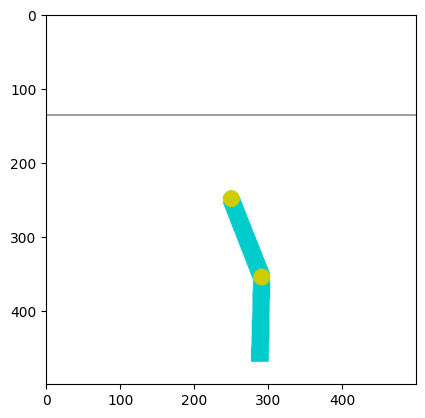

In [3]:
show_policy(env, None, n_episodes=1, max_steps=50)

3 - Create a neural network as a function approximator for the Q-function.

In [4]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library as in the cart-pole example

import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        # chidden layer 
        self.hidden_layer = torch.nn.Linear(512, 128)

        # output layer    
        self.output_layer = torch.nn.Linear(128, action_size)

    def forward(self, state):
       
        # convert the state into a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass hidden layer
        x = self.activation(self.hidden_layer(x))

        # finally, pass for the output layer
        q_values = self.output_layer(x)
        
        return q_values

    def select_action(self, state):

        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0)

        # calculate q_values from the network
        q_values = self(state).detach()

        # act greedy
        action = np.argmax(q_values).data.numpy()
        
        return action



4 - Add the code for the experience buffer

In [14]:
# YOUR CODE HERE

# Add the code for the experience buffer as in the cart-pole example

class ExperienceBuffer():
    def __init__(self, state_shape, buffer_size):
        self.buffer_size = buffer_size
        
        # prepare the buffer for the experience
        self.states = np.empty(shape=(buffer_size, state_shape), dtype=np.float32)
        self.actions = np.empty(shape=(buffer_size), dtype=np.int8)
        self.rewards = np.empty(shape=(buffer_size), dtype=np.float32)
        self.next_states = np.empty(shape=(buffer_size, state_shape), dtype=np.float32)
        self.is_failures = np.empty(shape=(buffer_size), dtype=np.int8)

        # update index
        self.next_index = 0

    def store(self, state, action, reward, next_state, is_failure):

        # store the experience in the buffer
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure

        # update index
        self.next_index += 1
    
    def get(self):
        # return experience
        return self.states, self.actions, self.rewards, self.next_states, self.is_failures

    def clear(self):
        # restart from the begging of the buffer
        self.next_index = 0

    def len(self):
        return self.next_index

5 - Add the code for the optimization function

In [5]:
# YOUR CODE HERE

# Add the code for calculating the TD-error and the loss function, as in the cart-pole example

def optimize(experiences, model, optimizer, gamma, epochs):
    
    # get the experience
    states, actions, rewards, next_states, is_failures = experiences  

    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()

    for _ in range(epochs):

        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants 
        q_next = model(next_states).detach()
        
        # get the max value 
        max_q_next = q_next.max(1)[0].unsqueeze(1)

        # one important step, often overlooked, is to ensure 
        # that failure states are grounded to zero
        max_q_next *= (1 - is_failures)

        # calculate the target 
        target = rewards + gamma * max_q_next

        # finally, we get the current estimate of Q(s,a)
        q_current = torch.gather(model(states), 1, actions)

        # create the errors
        td_error = target - q_current

        # calculate the loss
        value_loss = td_error.pow(2).mean()

        # optimize the network
        optimizer.zero_grad()
        value_loss.backward()
        optimizer.step()

6 - Add the code of two strategies for exploration and exploitation and the code for the evaluation of the policy

In [6]:
# YOUR CODE HERE

# Add the code for an exploration strategy based on the epsilon-greedy algorithm

import random

def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

In [7]:
# YOUR CODE HERE

# Add the code for a exploitation strategy based on the greedy algorithm

def greedy(approximator, state):
    return approximator.select_action(state)

In [8]:
# YOUR CODE HERE

# Add the code for an evaluation of the agent policy

def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

7 - Write the code of the NFQ algorithm

In [18]:
import time
import numpy as np
import random
from itertools import count

def nfq(env_name, seed, 
        batch_size, epochs, gamma, epsilon, learning_rate,
        max_episodes, max_time, max_score, episodes_window):

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the experience buffer 
    experience_buffer = ExperienceBuffer(state_size, batch_size) 

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the neural models
    model = Approximator(state_size, action_size)

    # create the optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan

    # train until we reach a terminal condition
    for episode in count():
    
        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0

        # reset the environment at the beginning of the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for episode_step in count():
                
            # select the action using the exploration policy
            action = epsilon_greedy(model, state, action_size, epsilon)
            
            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience
            experience_buffer.store(state, action, reward, next_state, is_failure)

            # if the experience collected so far is enough, optimize the model 
            # and clear the buffer
            if experience_buffer.len() == batch_size:
                optimize(experience_buffer.get(), model, optimizer, gamma, epochs)
                experience_buffer.clear()
        
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward

            # update the total steps
            total_step += 1
        
            if is_done:
                break

        # evaluate the learned policy after the episode
        score = evaluate(model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(episode_step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        training_time += episode_elapsed   
    
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, total steps {:06}, score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached max episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached max time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached max score ')
            break

    return model, score, results

8 - Apply NFQ to the environment 

In [21]:
# YOUR CODE HERE

# Apply NFQ to the environment 

# discount factor, exploration rate and learning rate
gamma = 0.99  
epsilon = 0.5
learning_rate = 0.0005

# training parameters
batch_size = 1024
epochs = 40

# max number of episodes to train
max_episodes = 3000
max_time = 4*60
max_score = -100
episodes_window = 50

# set the seed for reproducibility of results
seed = 97

# create the agent
q_function, score, result = nfq(env_name, seed, 
                                batch_size, epochs, gamma, epsilon, learning_rate,
                                max_episodes, max_time, max_score, episodes_window)

episode 0091, total steps 020383, score -99.4  --> reached max score 


9 - show the learning curves 

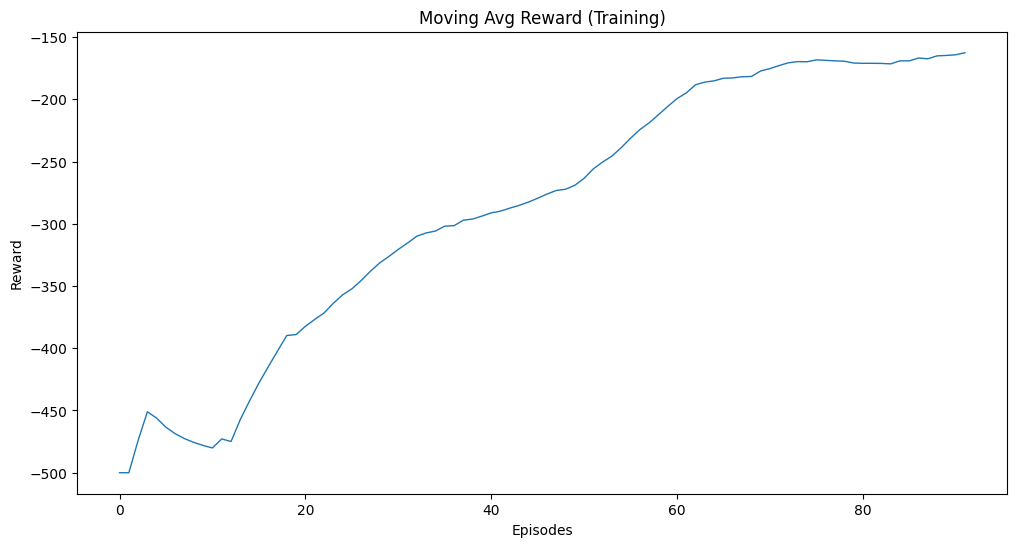

In [22]:
# YOUR CODE HERE

# Show the moving average reward of the training process

import matplotlib.pyplot as plt

steps, train_reward, eval_score, _ = result.T

plt.figure(figsize=(12,6))

plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

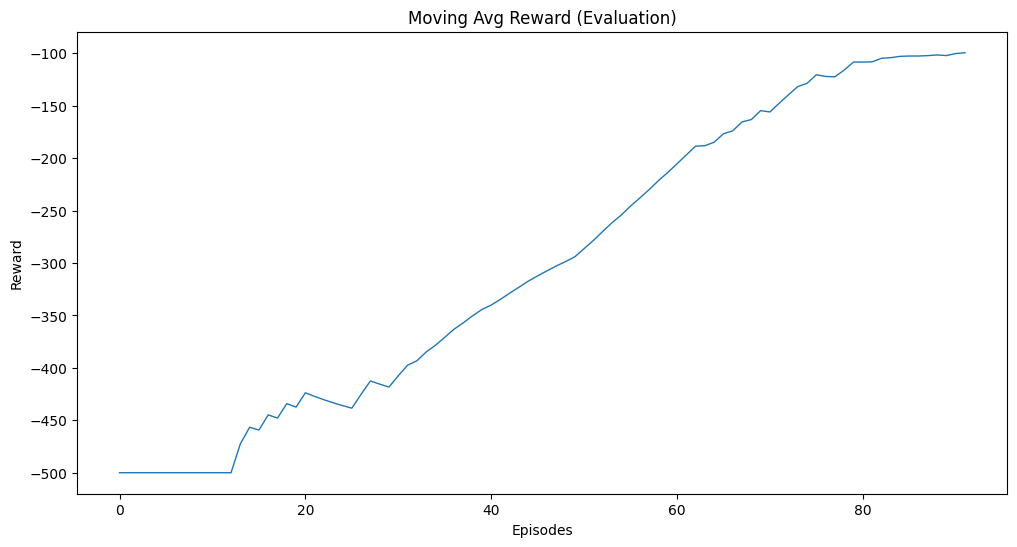

In [23]:
# YOUR CODE HERE

# Show the moving average reward of the evaluation process

plt.figure(figsize=(12,6))

plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

10 - show the policy behavior

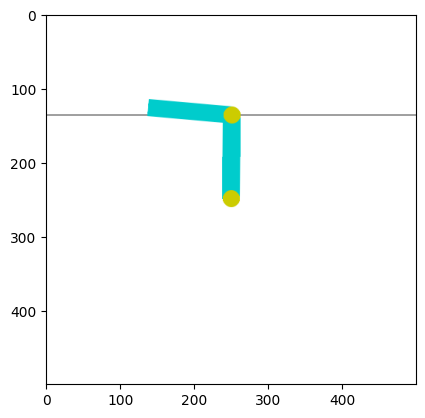

In [24]:
# YOUR CODE HERE

# You can show the policy learned by the agent using the show_policy function

show_policy(env, q_function, n_episodes=1)